In [45]:
!gdown --id 1ovYiBl-6XFBI9ooATficyPpY6aaZCYEk

Downloading...
From: https://drive.google.com/uc?id=1ovYiBl-6XFBI9ooATficyPpY6aaZCYEk
To: /content/Dataset 1.csv
100% 999k/999k [00:00<00:00, 30.5MB/s]


In [46]:
import matplotlib.pyplot as plt
import warnings
import time,sys
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary
from sklearn.utils import shuffle
!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

warnings.filterwarnings('ignore')
torch.manual_seed(0)

In [47]:
df = pd.read_csv('/content/Dataset 1.csv',encoding='unicode_escape')
df.columns

Index(['message', 'label'], dtype='object')

In [48]:
df['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [49]:
## split dataset based on the class
traning_split_size = 0.8
df_class_1 = df[df['label'] == 1]
df_class_0 = df[df['label'] == 0]

trainSize = int(len(df_class_0) * traning_split_size)
Traning_class_0 = df_class_0[:trainSize]
Test_class_0 = df_class_0[trainSize:]

trainSize = int(len(df_class_1) * traning_split_size)
Traning_class_1 = df_class_1[:trainSize]
Test_class_1 = df_class_1[trainSize:]

In [50]:
li = [Traning_class_0,Traning_class_1]
frame = pd.concat(li, axis=0, ignore_index=True)
frame = shuffle(frame)
frame.reset_index(inplace=True, drop=True)
frame.to_csv('Train-Dataset.csv',index=False)
frame

,message,label
0,"Hey @Audiophile021. It's been an age, man. Hop...",0
1,"Im on my way to the videoshoot!, get down ther...",0
2,@linzzerr Ialways thought Pauley Perrette(Abby...,0
3,@MarkRosenbauer LOL. He is one strange charact...,0
4,@dlsbeauty welcome to twitter,0
...,...,...
8246,"@Murraymilitia I would spiral into depression,...",1
8247,@authorlisalogan oooh cool cool thank you very...,0
8248,@joannasas may hang over pa ko sa bonding m0me...,0
8249,rt @ammr: ??????? ??? ???? ???? .. ???? ?? ??...,0


In [51]:
li = [Test_class_0,Test_class_1]
frame = pd.concat(li, axis=0, ignore_index=True)
frame = shuffle(frame)
frame.reset_index(inplace=True, drop=True)
frame.to_csv('Test-Dataset.csv',index=False)
frame

,message,label
0,@SQLChicken because it's programmed differently,0
1,I really want the sun to shine tmorro so I can...,0
2,My heads pounding. Off to bed! Bet you'll be h...,0
3,finished first 4-mi race in 33:09. 8:19-min mi...,0
4,@agwyllie Europe as its many countries... You ...,0
...,...,...
2058,I don't think people realize that depression i...,1
2059,"@jen_unwin @sandy_brighton From what I hear, I...",1
2060,Umm... why is Kobe a trending topic??? Is ther...,0
2061,Ughh! I have the stupid hiccups! Watching Supe...,0


In [52]:
import matplotlib.pyplot as plt
import warnings
import time,sys,re,string
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary
from sklearn.utils import shuffle
!pip install torchviz
from torchviz import make_dot, make_dot_from_trace
try:
  import contractions
except:
  !pip install contractions
import contractions
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vectors, GloVe

import nltk
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('averaged_perceptron_tagger')
    nltk.data.find('brown')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
    nltk.download('brown')
    nltk.download('punkt')
from nltk import sent_tokenize,word_tokenize


warnings.filterwarnings('ignore')
torch.manual_seed(0)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
traning_df = pd.read_csv('/content/Train-Dataset.csv')
testing_df = pd.read_csv('/content/Test-Dataset.csv')

In [54]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers. removibng miltiple full stop'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\.+', ".", text)
    return text

def replace_text(text):
    text = str(text).lower()
    text = text.encode('ascii', 'ignore').decode('utf-8') 
    return text  


for dta in [traning_df,testing_df]:
  dta['text_cleaning'] = dta['message'].apply(lambda x: x.strip().lower() )
  dta['text_cleaning'] = dta.text_cleaning.apply(lambda x : " ".join(x.split()) )
  dta['text_cleaning'] = dta.text_cleaning.apply(lambda x: contractions.fix(x) )
  dta['text_cleaning'] = dta.text_cleaning.apply(lambda x: clean_text(x) )
  dta['text_cleaning'] = dta.text_cleaning.apply(lambda x: replace_text(x) )
  dta['number_of_word'] = dta.text_cleaning.apply(lambda x: len(word_tokenize(x)) )
  dta['number_of_letter'] = dta.text_cleaning.apply(lambda x: len(x) )
  del dta['message']
  dta['message'] = dta['text_cleaning'] 
  del dta['text_cleaning']



for dta in [traning_df,testing_df]:
  word_count_zero = dta[dta['number_of_word'] == 0]
  dta.drop(word_count_zero.index,inplace=True)
  letter_count_zero = dta[dta['number_of_letter'] == 0]
  dta.drop(letter_count_zero.index,inplace=True)

In [55]:
alltext_length = []
allword_length = []
for val in traning_df['message']:
  word_tok = word_tokenize(val)
  alltext_length.append(len(val))
  allword_length.append(len(word_tok))

print(max(alltext_length))
print(max(allword_length))

289
62


In [56]:
for val in traning_df['message']:
  word_tok = word_tokenize(val)
  if len(word_tok) <= 1:
    print(val)

 thanks
lonlonraanch
party 
name
houseeee
makemescream
comeagainjen   
beeeeeeed
radiogrinch 
shopping
 whaaatever
 with 
twittermaniaaaaaaaaaaa
oneofusisfdup
  thirsty
remysoon
may    
llisalang
 yup
quickshooter                
depression  
katelyniscool   
jonathanrknight
incoming
depression  
ferngully
shaundiviney
reading
     subway
spurofmoment
fairyfreia          
depression  
 thanks
around
  updates
name
scarych         
 thanks
depression  
depression  
depression
picture
 sorite
 thanks
depression  
realworldmom


In [57]:
traning_df.to_csv('/content/Train-Dataset-prcessed.csv',index=False)
testing_df.to_csv('/content/Test-Dataset-prcessed.csv',index=False)

In [58]:
traning_df = pd.read_csv('/content/Train-Dataset-prcessed.csv')
testing_df = pd.read_csv('/content/Test-Dataset-prcessed.csv')

In [69]:
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('polarity', label_field),  ('text', text_field)]


train_data = TabularDataset(path="/content/Train-Dataset-prcessed.csv",
                                 format="csv",
                                  fields=fields,
                                 skip_header=True)

valid_data = TabularDataset(path="/content/Test-Dataset-prcessed.csv",
                                 format="csv",
                                  fields=fields,
                                 skip_header=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iter = BucketIterator(train_data, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_data, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)


text_field.build_vocab(train_data,) # min_freq=3,vectors = "glove.6B.100d"
label_field.build_vocab(train_data)

In [70]:
class CNN(torch.nn.Module): 
    def __init__(self , vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super(CNN, self).__init__()

        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        #initializing convolution layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)

        #initializing dropout 
        self.dropout = torch.nn.Dropout(0.2)

        #initializing MaxPool2d 
        self.pool= torch.nn.MaxPool2d(2,2)
 
        #initializing linear
        self.fc1 = torch.nn.Linear(64* 1* 1, 512)
        self.fc2 = torch.nn.Linear(512,64)
        self.fc3 = torch.nn.Linear(64,output_dim)

 
    def forward(self, text):
        embedded = self.embedding(text)
        x = embedded.view(-1,1,16,16) 
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.nn.functional.relu(self.conv2(x))) 
        x = self.dropout(x)
        x = self.pool(torch.nn.functional.relu(self.conv3(x))) 
        x = x.view(-1, 64* 1* 1) 
        # x = self.pool(torch.nn.functional.relu(x)) 
        # x = x.view(-1, 32* 1* 1) 
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [71]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.0001

INPUT_DIM = len(text_field.vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = text_field.vocab.stoi[text_field.pad_token] # padding

In [72]:
!pip install torchinfo

In [73]:
model = CNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX).to(device)

from torchinfo import summary
summary( model, input_size=(1, 10),dtypes=[torch.long],)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Embedding: 1-1                         [1, 10, 256]              16,384
├─Conv2d: 1-2                            [10, 16, 14, 14]          160
├─MaxPool2d: 1-3                         [10, 16, 7, 7]            --
├─Dropout: 1-4                           [10, 16, 7, 7]            --
├─Conv2d: 1-5                            [10, 32, 5, 5]            4,640
├─MaxPool2d: 1-6                         [10, 32, 2, 2]            --
├─Dropout: 1-7                           [10, 32, 2, 2]            --
├─Conv2d: 1-8                            [10, 64, 2, 2]            2,112
├─MaxPool2d: 1-9                         [10, 64, 1, 1]            --
├─Linear: 1-10                           [10, 512]                 33,280
├─Linear: 1-11                           [10, 64]                  32,832
├─Linear: 1-12                           [10, 1]                  

In [74]:
model.to(device)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
def binary_accuracy(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [76]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i,batch in enumerate( iterator,1):
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, batch.polarity)
        acc = binary_accuracy(predictions, batch.polarity)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        print_val = f"running_loss : {(loss.item()):.6f}\t"
        print_val += f"running_corrects : {acc.item():.6f}\t"  
        sys.stdout.write('\r' + str(print_val))
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [77]:
def evaluate(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text,).squeeze(1)
            loss = criterion(predictions, batch.polarity)
            acc = binary_accuracy(predictions, batch.polarity)
            
            epoch_acc += acc.item()
            epoch_loss += loss.item()
        
    return  epoch_loss / len(iterator), epoch_acc / len(iterator) 

In [78]:
t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iter)
    valid_loss, valid_acc = evaluate(model, valid_iter)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%  | Val. Acc: {valid_acc*100:.2f}%')
    # print(f'\t')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

running_loss : 0.564237	running_corrects : 0.750000		Train Loss: 0.541 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.566317	running_corrects : 0.750000		Train Loss: 0.531 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.549377	running_corrects : 0.750000		Train Loss: 0.529 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.558645	running_corrects : 0.750000		Train Loss: 0.528 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.562701	running_corrects : 0.750000		Train Loss: 0.526 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.548458	running_corrects : 0.750000		Train Loss: 0.524 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.569930	running_corrects : 0.750000		Train Loss: 0.519 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.560010	running_corrects : 0.750000		Train Loss: 0.514 | Train Acc: 77.59%  | Val. Acc: 77.38%
running_loss : 0.538082	running_corrects : 0.750000		Train Loss: 0.506 | Train Acc: 77.59%  | Val. Acc: 78.72%
r

In [79]:
import glob,sys,os
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sn
import pandas as pd
import pathlib
import zipfile
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import time,sys
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [80]:
_tranning_loss = loss
_tranning_acc = acc
_validation_loss = val_loss
_validation_acc = val_acc

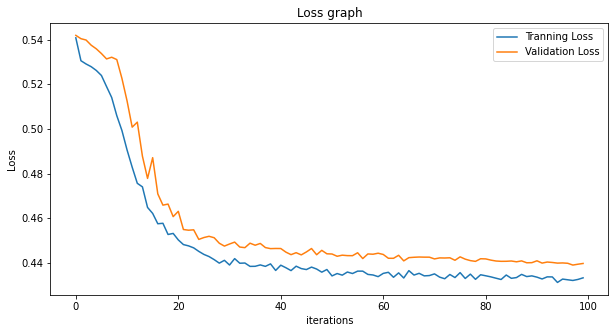

In [83]:
plt.figure(figsize=(10,5))
plt.title("Loss graph")
plt.plot(_tranning_loss,label="Tranning Loss")
plt.plot(_validation_loss,label="Validation Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

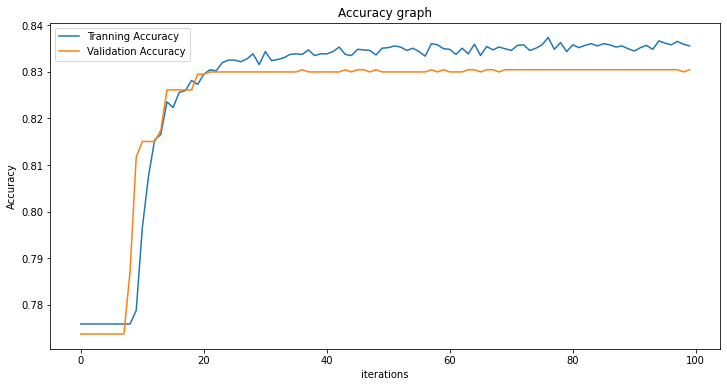

In [81]:
plt.figure(figsize=(12,6))
plt.title("Accuracy graph")
plt.plot(_tranning_acc,label="Tranning Accuracy")
plt.plot(_validation_acc,label="Validation Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [84]:
y_true_tensor = torch.tensor([])
y_pred_tensor = torch.tensor([])
model.eval()
with torch.no_grad():
      for batch in valid_iter:
          text, text_lengths = batch.text
          predictions = model(text).squeeze(1)

          rounded_preds = torch.round(torch.sigmoid(predictions))
          correct = (rounded_preds == batch.polarity).float() 

          # print(rounded_preds,batch.polarity)

          y_true_tensor = torch.cat((y_true_tensor,batch.polarity))
          y_pred_tensor = torch.cat((y_pred_tensor,rounded_preds))
          # acc = binary_accuracy(predictions, batch.polarity)
          # print(acc)

In [85]:
y_true = y_true_tensor.type(torch.LongTensor).tolist()
y_pred = y_pred_tensor.type(torch.LongTensor).tolist()

In [86]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[1584,   14],
       [ 333,  128]])

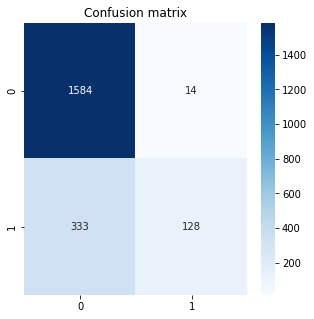

In [87]:
df_cm = pd.DataFrame(cm,columns=[0,1],index=[0,1])
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g',cmap='Blues',)
plt.title(f"Confusion matrix")
plt.show()

In [88]:
classify_report = classification_report(y_true, y_pred, )
print(classify_report)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1598
           1       0.90      0.28      0.42       461

    accuracy                           0.83      2059
   macro avg       0.86      0.63      0.66      2059
weighted avg       0.84      0.83      0.79      2059

